# **PMR3508(2020) - Aprendizado de Máquina e Reconhecimento de Padrões**

Análise e aplicação de um regressor linear para prever o valor de casas localizadas na Califórnia;

Autor: Gabriel Ranieri Vaz de Lima

# **1. Preparação dos Dados (*Data Prep*)**

* **Importação de Bibliotecas**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopy
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

* **Importação dos Dados**

In [2]:
housing_train = pd.read_csv("../input/atividade-regressao-PMR3508/train.csv", 
        names = ["Id", "Longitude","Latitude","Median_Age","Total_Rooms", "Total_Bedrooms",
                      "Population", "Households", "Median Income", "Median House Value"],
        sep=r'\s*,\s*',
        skiprows=1,
        engine='python',
        na_values="?")

housing_test = pd.read_csv("../input/atividade-regressao-PMR3508/test.csv",
        names = ["Id", "Longitude","Latitude","Median_Age","Total_Rooms", "Total_Bedrooms",
                      "Population", "Households", "Median Income"],
        sep=r'\s*,\s*',
        skiprows=1,
        engine='python',
        na_values="?")

In [3]:
housing_train.head()

,Id,Longitude,Latitude,Median_Age,Total_Rooms,Total_Bedrooms,Population,Households,Median Income,Median House Value
0,15817,-120.85,37.57,27,819,157,451,150,34934,193800
1,6236,-117.74,34.06,48,2438,599,1508,548,28983,129200
2,19262,-118.11,33.92,32,1016,190,729,177,43000,151300
3,19743,-118.12,34.15,35,1760,447,984,384,34167,198200
4,7272,-120.63,37.41,27,2083,444,1462,479,26439,69100


* **Identificação de dados faltantes (Missing Data)**

In [4]:
print('Formato do DataFrame: ', housing_train.shape)

Formato do DataFrame:  (14448, 10)


Acima, a descrição da estrutura do Dataframe.

In [5]:
housing_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14448 entries, 0 to 14447
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  14448 non-null  int64  
 1   Longitude           14448 non-null  float64
 2   Latitude            14448 non-null  float64
 3   Median_Age          14448 non-null  int64  
 4   Total_Rooms         14448 non-null  int64  
 5   Total_Bedrooms      14448 non-null  int64  
 6   Population          14448 non-null  int64  
 7   Households          14448 non-null  int64  
 8   Median Income       14448 non-null  int64  
 9   Median House Value  14448 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.1 MB


Verifica-se que inexistem dados faltantes, a partir das informações do Dataframe dispostas acima.

# **2. Análise dos Dados**

Nesta etapa, busca-se compreender como os dados se comportam, além de procurar atributos similares, complementares ou pouco relevantes. Como irá se estimar o valor médio de uma casa, é importante entender como os atributos influenciam essa etimativa para manipulá-los e filtrá-los.

* **Correlação de variáveis**

In [6]:
housing_train.apply(preprocessing.LabelEncoder().fit_transform).corr()

,Id,Longitude,Latitude,Median_Age,Total_Rooms,Total_Bedrooms,Population,Households,Median Income,Median House Value
Id,1.000000,0.004861,-0.005471,-0.013166,-0.001809,0.004592,0.007819,0.002625,-0.008955,-0.005995
Longitude,0.004861,1.000000,-0.924265,-0.108463,0.021323,0.059517,0.104862,0.046785,-0.016769,-0.043265
Latitude,-0.005471,-0.924265,1.000000,0.015517,-0.022133,-0.061980,-0.123298,-0.069391,-0.090014,-0.158218
Median_Age,-0.013166,-0.108463,0.015517,1.000000,-0.377217,-0.335666,-0.310299,-0.314679,-0.153690,0.090254
Total_Rooms,-0.001809,0.021323,-0.022133,-0.377217,1.000000,0.903543,0.829951,0.895935,0.267129,0.193667
Total_Bedrooms,0.004592,0.059517,-0.061980,-0.335666,0.903543,1.000000,0.871452,0.978588,0.008414,0.075754
Population,0.007819,0.104862,-0.123298,-0.310299,0.829951,0.871452,1.000000,0.903266,0.013812,-0.011176
Households,0.002625,0.046785,-0.069391,-0.314679,0.895935,0.978588,0.903266,1.000000,0.038744,0.095021
Median Income,-0.008955,-0.016769,-0.090014,-0.153690,0.267129,0.008414,0.013812,0.038744,1.000000,0.676480
Median House Value,-0.005995,-0.043265,-0.158218,0.090254,0.193667,0.075754,-0.011176,0.095021,0.676480,1.000000


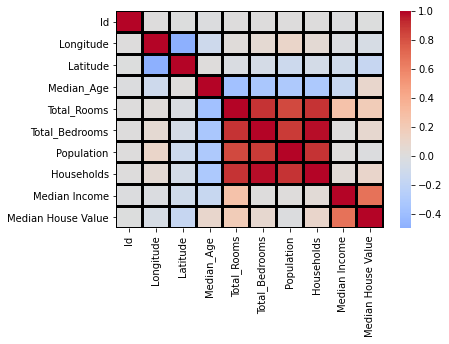

In [7]:
housing_train_corr = housing_train.apply(preprocessing.LabelEncoder().fit_transform).corr()
sns.heatmap(housing_train_corr, vmin=-0.5, vmax=1, center=0, cmap='coolwarm', linewidths=2, linecolor='black')

A partir da tabela e do heatmap, extrai-se que o valor mediano de uma casa (valor que busca-se estimar) está muito relacionado com a renda média e relativamente pouco com os outros atributos (Quanto mais próximo do 1 ou do -1, maior é a relação).

Além disso, observa-se uma conexão entre latitude e longitude, por isso essas variáveis serão estudadas para se interpretar como as coordenadas geográficas, as quais representam, realmente influenciam o valor mediano das casas.

Também existe uma relevante correlação entre as variáveis: Total_Rooms, Total_Bedrooms, Population e Households, portanto irá se verificar como proporções entre elas relacionam-se com o valor que se busca estimar.

Por fim, é importante ressaltar que a variável Median Age também se associa com as quatro citadas anteriormente, porém menos intensamente. 

* **Localização (Longitude e Latitude)**

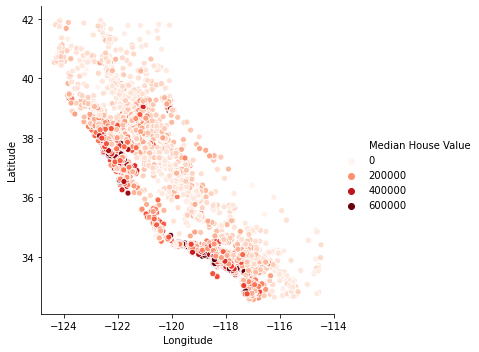

In [8]:
#Utiliza-se da biblioteca seaborn para a criação do gráfico longitude X latitude
sns.relplot(data=housing_train, x="Longitude", y="Latitude", hue="Median House Value", palette="Reds")

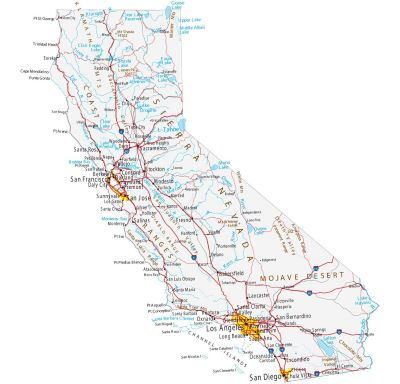](https://gisgeography.com/california-map/)

Como podemos observar, as localização das casas com maior valor mediano concentram-se principalmente próximas das cidades de Los Angeles e San Francisco. Portanto, ao se substituir longitude e latitude pela menor distância a uma dessas 2 principais cidades, melhora-se a previsão do valor mediano da casa.

**Coordenadas geográficas (latitude, longitude):**

Los Angeles: (34.0194,  -118.411)

San Francisco: (37.7272, -123.032)

In [9]:
#Utilizando-se da biblioteca geopy, define-se a menor distância a uma das duas cidades:
import geopy.distance
def minimum_distance_to():
    
    cities = {"Los Angeles": (34.0194, -118.411), "San Francisco": (37.7272, -123.032)}
    
    latitude = housing_train.Latitude.to_list()    #Transforma as colunas "Latitude" e "Longitude"
    longitude = housing_train.Longitude.to_list()  #em listas
    point={}
    
    k=0
    while k < len(latitude):   #Define a coordenada geográfica de cada casa
        point[k]=(latitude[k],longitude[k])
        k+=1
        
    shortest_distance=[]
    
    for k in point: #Encontra a distância de cada coordenada às 2 cidades e seleciona a menor
        s_distance=0
        for city in cities:
            distance =  geopy.distance.distance(point[k], cities[city]).km
            if s_distance == 0:
                s_distance = distance
            if distance < s_distance:
                s_distance = distance
        shortest_distance.append(s_distance)
        
    housing_train["Distance to Important City"] = shortest_distance #Cria uma coluna para a distância
    
    
    #Faz-se o mesmo para os dados de teste
    cities = {"Los Angeles": (34.0194, -118.411), "San Francisco": (37.7272, -123.032)}
    
    latitude = housing_test.Latitude.to_list()    
    longitude = housing_test.Longitude.to_list()  
    point={}
    
    k=0
    while k < len(latitude):  
        point[k]=(latitude[k],longitude[k])
        k+=1
        
    shortest_distance=[]
    
    for k in point: 
        s_distance=0
        for city in cities:
            distance =  geopy.distance.distance(point[k], cities[city]).km
            if s_distance == 0:
                s_distance = distance
            if distance < s_distance:
                s_distance = distance
        shortest_distance.append(s_distance)
        
    housing_test["Distance to Important City"] = shortest_distance 
    
minimum_distance_to()

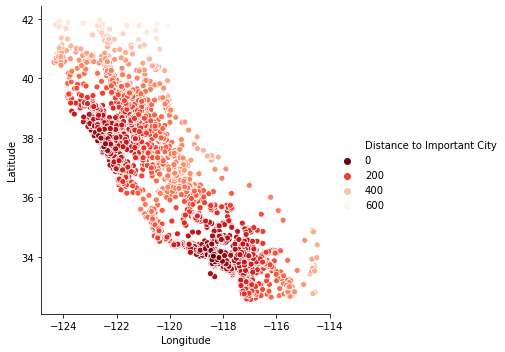

In [10]:
sns.relplot(data=housing_train, x="Longitude", y="Latitude", hue="Distance to Important City", 
            palette="Reds_r")

In [11]:
housing_train.head()

,Id,Longitude,Latitude,Median_Age,Total_Rooms,Total_Bedrooms,Population,Households,Median Income,Median House Value,Distance to Important City
0,15817,-120.85,37.57,27,819,157,451,150,34934,193800,193.345649
1,6236,-117.74,34.06,48,2438,599,1508,548,28983,129200,62.124670
2,19262,-118.11,33.92,32,1016,190,729,177,43000,151300,29.923025
3,19743,-118.12,34.15,35,1760,447,984,384,34167,198200,30.515154
4,7272,-120.63,37.41,27,2083,444,1462,479,26439,69100,215.097563


* **Bedrooms per Rooms**



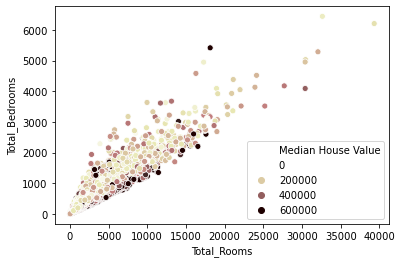

In [12]:
sns.scatterplot(data=housing_train,  x="Total_Rooms", y="Total_Bedrooms", hue="Median House Value",
            palette="pink_r")

É possível constatar que o valor mediano de uma casa é maior principalmente quando existem menos quartos por cômodo. Enquanto os menores preços das casas concentram-se mais próximos da média dos valores da razão quartos por cômodo.

In [13]:
def bed_per_rooms():
    bedrooms = housing_train.Total_Bedrooms.to_list() #Transforma as colunas "Bedrooms" e "Rooms"
    rooms = housing_train.Total_Rooms.to_list()       # em listas
    bedperroom=[]
    k=0
    while k<len(bedrooms):      #Calcula a razão entre quartos e cômodos
        bpr=bedrooms[k]/rooms[k]
        bedperroom.append(bpr)
        k+=1
        
    housing_train["Bedrooms per Rooms"]=bedperroom #Cria uma coluna para a razão entre quartos e cômodos
    
    
    #Faz-se o mesmo para os dados de teste
    bedrooms = housing_test.Total_Bedrooms.to_list()
    rooms = housing_test.Total_Rooms.to_list()
    bedperroom=[]
    k=0
    while k<len(bedrooms):
        bpr=bedrooms[k]/rooms[k]
        bedperroom.append(bpr)
        k+=1
        
    housing_test["Bedrooms per Rooms"]=bedperroom
    
bed_per_rooms()

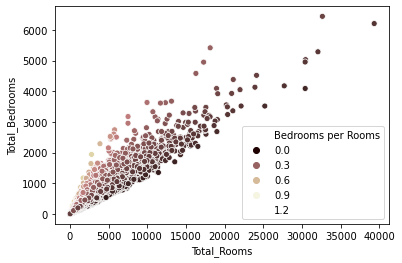

In [14]:
sns.scatterplot(data=housing_train,  x="Total_Rooms", y="Total_Bedrooms", hue="Bedrooms per Rooms",
            palette="pink")

In [15]:
housing_train.head()

,Id,Longitude,Latitude,Median_Age,Total_Rooms,Total_Bedrooms,Population,Households,Median Income,Median House Value,Distance to Important City,Bedrooms per Rooms
0,15817,-120.85,37.57,27,819,157,451,150,34934,193800,193.345649,0.191697
1,6236,-117.74,34.06,48,2438,599,1508,548,28983,129200,62.124670,0.245693
2,19262,-118.11,33.92,32,1016,190,729,177,43000,151300,29.923025,0.187008
3,19743,-118.12,34.15,35,1760,447,984,384,34167,198200,30.515154,0.253977
4,7272,-120.63,37.41,27,2083,444,1462,479,26439,69100,215.097563,0.213154


* **Households per Person**

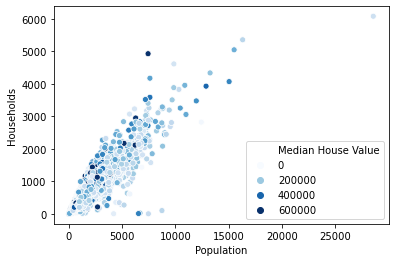

In [16]:
sns.scatterplot(data=housing_train,  x="Population", y="Households", hue="Median House Value",
            palette="Blues")

Percebe-se que o valor mediano da casa aumenta quanto maior a proporção entre Households e Population.

In [17]:
def households_per_person():
    households = housing_train.Households.to_list() #Transforma as colunas "Households" e "Population"
    population = housing_train.Population.to_list() #em listas
    house_per_person=[]
    k=0
    while k<len(households):     #Calcula a razão entre households e população
        hpp=households[k]/population[k]
        house_per_person.append(hpp)
        k+=1
        
    housing_train["Households per Person"]=house_per_person #Cria uma coluna para a razão entre households e população
    
    
    #Faz-se o mesmo para os dados de teste
    households = housing_test.Households.to_list()
    population = housing_test.Population.to_list()
    house_per_person=[]
    k=0
    while k<len(households):
        hpp=households[k]/population[k]
        house_per_person.append(hpp)
        k+=1
        
    housing_test["Households per Person"]=house_per_person
    
households_per_person()

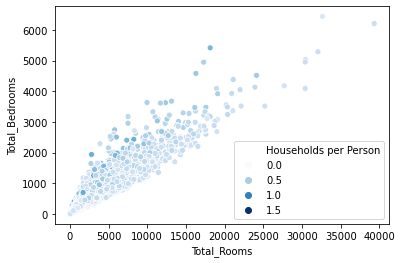

In [18]:
sns.scatterplot(data=housing_train,  x="Total_Rooms", y="Total_Bedrooms", hue="Households per Person",
            palette="Blues")

* **Análise das novas features**

In [19]:
housing_train.apply(preprocessing.LabelEncoder().fit_transform).corr()

,Id,Longitude,Latitude,Median_Age,Total_Rooms,Total_Bedrooms,Population,Households,Median Income,Median House Value,Distance to Important City,Bedrooms per Rooms,Households per Person
Id,1.000000,0.004861,-0.005471,-0.013166,-0.001809,0.004592,0.007819,0.002625,-0.008955,-0.005995,-0.014292,0.014888,-0.018982
Longitude,0.004861,1.000000,-0.924265,-0.108463,0.021323,0.059517,0.104862,0.046785,-0.016769,-0.043265,-0.237981,0.086802,-0.174038
Latitude,-0.005471,-0.924265,1.000000,0.015517,-0.022133,-0.061980,-0.123298,-0.069391,-0.090014,-0.158218,0.419444,-0.098261,0.164815
Median_Age,-0.013166,-0.108463,0.015517,1.000000,-0.377217,-0.335666,-0.310299,-0.314679,-0.153690,0.090254,-0.335112,0.162812,0.037131
Total_Rooms,-0.001809,0.021323,-0.022133,-0.377217,1.000000,0.903543,0.829951,0.895935,0.267129,0.193667,0.030361,-0.224712,0.135192
Total_Bedrooms,0.004592,0.059517,-0.061980,-0.335666,0.903543,1.000000,0.871452,0.978588,0.008414,0.075754,-0.028661,0.114960,0.167725
Population,0.007819,0.104862,-0.123298,-0.310299,0.829951,0.871452,1.000000,0.903266,0.013812,-0.011176,-0.082061,0.062216,-0.223434
Households,0.002625,0.046785,-0.069391,-0.314679,0.895935,0.978588,0.903266,1.000000,0.038744,0.095021,-0.060690,0.085229,0.139294
Median Income,-0.008955,-0.016769,-0.090014,-0.153690,0.267129,0.008414,0.013812,0.038744,1.000000,0.676480,-0.205143,-0.744430,0.040798
Median House Value,-0.005995,-0.043265,-0.158218,0.090254,0.193667,0.075754,-0.011176,0.095021,0.676480,1.000000,-0.453596,-0.339929,0.274776


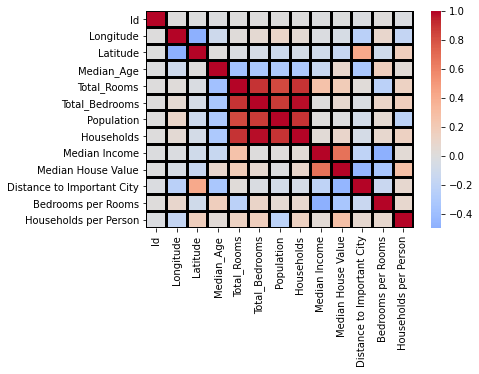

In [20]:
housing_train_corr = housing_train.apply(preprocessing.LabelEncoder().fit_transform).corr()
sns.heatmap(housing_train_corr, vmin=-0.5, vmax=1, center=0, cmap='coolwarm', linewidths=2, linecolor='black')

Conclui-se que as novas features relacionam-se mais com a que se deseja estimar (Median House Value) comparado às antigas. 

# 3. **Aplicação de Modelos de Regressão**

Neste segmento, serão realizados a seleção des features e o teste em modelos de regressão.

In [21]:
housing_train1 = housing_train[["Latitude", "Longitude", "Median_Age", "Total_Rooms", "Total_Bedrooms",
                                "Median Income", "Distance to Important City", "Bedrooms per Rooms",
                                "Households per Person", "Median House Value" ]]

Escolheu-se pelo descarte das features: Population e Households, além do Id, pois pouco impactam na predição do preço mediano das casas, conforme verificou-se no segmento de análise dos dados.

In [22]:
housing_train1.head()

,Latitude,Longitude,Median_Age,Total_Rooms,Total_Bedrooms,Median Income,Distance to Important City,Bedrooms per Rooms,Households per Person,Median House Value
0,37.57,-120.85,27,819,157,34934,193.345649,0.191697,0.332594,193800
1,34.06,-117.74,48,2438,599,28983,62.124670,0.245693,0.363395,129200
2,33.92,-118.11,32,1016,190,43000,29.923025,0.187008,0.242798,151300
3,34.15,-118.12,35,1760,447,34167,30.515154,0.253977,0.390244,198200
4,37.41,-120.63,27,2083,444,26439,215.097563,0.213154,0.327633,69100


* **Normalização dos dados**

Utilizou-se o Standard Scaler da biblioteca sklearn para normalizar os dados.

In [23]:
housing_train_norm = preprocessing.StandardScaler().fit_transform(housing_train1.drop(["Median House Value"], axis = 1))
housing_train_norm

array([[ 0.90909061, -0.64090264, -0.13506141, ...,  0.95750765,
        -0.36780146, -0.34388237],
       [-0.73215774,  0.90788138,  1.53331707, ..., -0.54537713,
         0.55821096, -0.01491659],
       [-0.79762064,  0.7236209 ,  0.26217156, ..., -0.91418525,
        -0.44822161, -1.30293501],
       ...,
       [ 1.41409011, -0.87994326, -0.45284779, ...,  0.81491033,
         0.01157085,  0.94401969],
       [-0.75086143,  0.59414057,  1.2155307 , ..., -1.21351774,
         0.38505982,  0.2083725 ],
       [-0.74150958,  0.80330111,  0.57995794, ..., -0.76858481,
        -0.36996764, -1.66650224]])

In [24]:
#Cria um conjunto de validação
X, Xtest, Y, Ytest = train_test_split(housing_train_norm, housing_train1["Median House Value"], test_size = 0.2)

* **Root Mean Squared Logarithmic Error**

In [25]:
def RMSLE(Ytest, Ypred): #Determina o Root Mean Squared Logarithmic Error
    
    MSLE = np.mean([(np.log(np.abs(Ypred)+1) - np.log(np.abs(Ytest)+1))**2])
    return np.sqrt(MSLE)

*  **Regressão Linear**

In [26]:
from sklearn.linear_model import LinearRegression

RL = LinearRegression().fit(X,Y)

Ypred = RL.predict(Xtest)

rmsle_LinearRegression = RMSLE(Ytest, Ypred)

print("RMSLE:", rmsle_LinearRegression)

RMSLE: 0.43845732283700123


* **Ridge Regression**

In [27]:
from sklearn.linear_model import RidgeCV

RidgeR = RidgeCV().fit(X,Y)

Ypred = RidgeR.predict(Xtest)

rmsle_RidgeRegression = RMSLE(Ytest, Ypred)

print("RMSLE:", rmsle_RidgeRegression)

RMSLE: 0.43782891977203203


* **Lasso**

In [28]:
from sklearn.linear_model import Lasso

lasso = Lasso().fit(X,Y)

Ypred = lasso.predict(Xtest)

rmsle_lasso = RMSLE(Ytest, Ypred)

print("RMSLE:", rmsle_lasso)

RMSLE: 0.43833337846950743


* **KNN Regresssor**

In [29]:
from sklearn.neighbors import KNeighborsRegressor

BestK = 1
BestRmsle = 10

for k in range(1, 40):
    knnR = KNeighborsRegressor(n_neighbors = k).fit(X,Y)
    Ypred= knnR.predict(Xtest)
    rmsle_knnR = RMSLE(Ytest, Ypred)
    
    print('k = ', k, ' ;  RMSLE: ', rmsle_knnR)
    print('\n')
    if rmsle_knnR < BestRmsle:
        BestRmsle = rmsle_knnR

print('Melhor RMSLE: ', BestRmsle)

k =  1  ;  RMSLE:  0.347891321953986


k =  2  ;  RMSLE:  0.30353141760259084


k =  3  ;  RMSLE:  0.28926883359393946


k =  4  ;  RMSLE:  0.28349574414548295


k =  5  ;  RMSLE:  0.2788950154499061


k =  6  ;  RMSLE:  0.27711329067880297


k =  7  ;  RMSLE:  0.2772158267470857


k =  8  ;  RMSLE:  0.2777550034946853


k =  9  ;  RMSLE:  0.2771003158930685


k =  10  ;  RMSLE:  0.2781901854797005


k =  11  ;  RMSLE:  0.27816827549072265


k =  12  ;  RMSLE:  0.2777637899581094


k =  13  ;  RMSLE:  0.2785191303865665


k =  14  ;  RMSLE:  0.27898002111663384


k =  15  ;  RMSLE:  0.27868803173774287


k =  16  ;  RMSLE:  0.28029331651135814


k =  17  ;  RMSLE:  0.28076357599671464


k =  18  ;  RMSLE:  0.2817696144891188


k =  19  ;  RMSLE:  0.28190799935131655


k =  20  ;  RMSLE:  0.2817557798124276


k =  21  ;  RMSLE:  0.2819909429253466


k =  22  ;  RMSLE:  0.28302703360153963


k =  23  ;  RMSLE:  0.28360185524783965


k =  24  ;  RMSLE:  0.28394078273596385


k =  25  ;  R

Com base nos resultados em cada modelo, conclui-se que o KNN Regressor obteve o menor erro e, portanto, será o utilizado para a predição.
Também se escolhe 19 como valor de k.

# 4.  Predição e Submissão

Por fim, faz-se a previsão com os dados de treino e formatamos os resultados para csv.

In [30]:
train_X = housing_train[["Latitude", "Longitude", "Median_Age", "Total_Rooms", "Total_Bedrooms",
                                "Median Income", "Distance to Important City", "Bedrooms per Rooms",
                                "Households per Person" ]]

train_Y = housing_train[["Median House Value"]] 

In [31]:
train_X_norm = preprocessing.StandardScaler().fit_transform(train_X)

In [32]:
test = housing_test[["Latitude", "Longitude", "Median_Age", "Total_Rooms", "Total_Bedrooms",
                                "Median Income", "Distance to Important City", "Bedrooms per Rooms",
                                "Households per Person"]]
test.head()

,Latitude,Longitude,Median_Age,Total_Rooms,Total_Bedrooms,Median Income,Distance to Important City,Bedrooms per Rooms,Households per Person
0,34.30,-118.67,5,6123,825,79013,39.232506,0.134738,0.301639
1,34.09,-117.66,26,1151,200,36667,69.777150,0.173762,0.317032
2,35.37,-118.93,34,2412,446,26903,157.193471,0.184909,0.270218
3,34.14,-117.23,16,2577,521,25625,109.821574,0.202173,0.493724
4,38.98,-121.06,14,2267,355,47019,221.463576,0.156595,0.323684


In [33]:
#Normalização dos dados de treino
test_norm = preprocessing.StandardScaler().fit_transform(test)

In [34]:
knnR=knnR = KNeighborsRegressor(n_neighbors = 19).fit(train_X_norm,train_Y)
prediction = knnR.predict(test_norm)
submission = pd.DataFrame()
submission['Id'] = housing_test['Id']
submission['median_house_value'] = prediction
submission.head()

,Id,median_house_value
0,8609,327436.842105
1,14610,169921.052632
2,1557,70705.263158
3,12875,179431.631579
4,17821,183731.578947


In [35]:
submission.shape

(6192, 2)

In [36]:
submission.to_csv('submission.csv', index = False)